
# Pseudobatch transformation with uncertainties

This notebook describes how to use the Pseudobatch transformation with error propagation of the measurement uncertainties. This utilizes a Bayesian model which is provided as a precompiled model implemented in the programming language [Stan](https://mc-stan.org/).

## Imports

In [1]:
import logging

from itertools import islice

import arviz as az
import cmdstanpy
import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from scipy.special import logit

from pseudobatch.data_correction import pseudobatch_transform
from pseudobatch.datasets import load_standard_fedbatch
from pseudobatch.error_propagation import run_error_propagation

cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

{'stan_version_major': '2', 'stan_version_minor': '31', 'stan_version_patch': '0', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


## Loading data

This cell uses the function `load_standard_fedbatch` from pseudobatch's `datasets` module to load a standard dataset. It then adds some columns that will be useful later.

In [2]:
SPECIES = ["Biomass", "Glucose", "Product"]
samples = load_standard_fedbatch(sampling_points_only=True)
samples["v_Feed_interval"] = np.concatenate(
    [np.array([samples["v_Feed_accum"].iloc[0]]), np.diff(samples["v_Feed_accum"])]
)
for species in SPECIES:
    samples[f"c_{species}_pseudobatch"] = pseudobatch_transform(
        measured_concentration=samples[f"c_{species}"],
        reactor_volume=samples["v_Volume"],
        accumulated_feed=samples["v_Feed_accum"],
        concentration_in_feed=100 if species == "Glucose" else 0,
        sample_volume=samples["sample_volume"],
    )
samples

,Kc_s,mu_max,Yxs,Yxp,Yxco2,F0,mu0,s_f,sample_volume,timestamp,...,v_Feed_accum,c_Glucose,c_Biomass,c_Product,c_CO2,mu_true,v_Feed_interval,c_Biomass_pseudobatch,c_Glucose_pseudobatch,c_Product_pseudobatch
0,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,100.0,10.000000,...,15.906036,0.075012,1.337854,0.694737,0.038219,0.100011,15.906036,1.337854,0.075012,0.694737
1,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,100.0,14.545455,...,28.960902,0.075010,2.078116,1.308552,0.071987,0.100009,13.054865,2.107737,-1.349271,1.327204
2,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,100.0,19.090909,...,47.314262,0.075111,3.203015,2.241303,0.123300,0.100099,18.353360,3.320595,-3.593059,2.323579
3,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,100.0,23.636364,...,72.816654,0.075020,4.879772,3.631646,0.199786,0.100018,25.502392,5.231542,-7.128310,3.893442
4,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,100.0,28.181818,...,107.795685,0.075064,7.307921,5.645033,0.310547,0.100057,34.979030,8.242050,-12.697749,6.366604
5,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,100.0,32.727273,...,155.117789,0.075010,10.681703,8.442525,0.464444,0.100009,47.322105,12.985050,-21.472300,10.263028
6,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,100.0,37.272727,...,218.291500,0.075015,15.109112,12.113671,0.666403,0.100014,63.173711,20.457389,-35.296127,16.401631
7,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,100.0,41.818182,...,301.721795,0.075044,20.503292,16.586449,0.912462,0.100039,83.430295,32.229719,-57.074938,26.072721
8,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,100.0,46.363636,...,411.318523,0.075043,26.510976,21.567936,1.186506,0.100038,109.596728,50.776554,-91.386583,41.309136
9,0.15,0.3,1.85,0.82151,0.045193,0.159031,0.1,100.0,100.0,50.909091,...,555.738790,0.075049,32.568141,26.590453,1.462807,0.100044,144.420266,79.996288,-145.443091,65.313447


## Specifying priors

The next cell specifies the prior distributions required for pseudobatch's error propagation function. These are set by choosing values for percentiles. Note that it is also possible to set prior distributions using location and scale parameters, for example:

```
priors = {
    ...
    prior_v0: {"mu": 0, "sigma": 1},
    ...
}
```

In [3]:
priors = {
    "prior_apump": {"pct1": np.log(1 - 0.1), "pct99": np.log(1 + 0.1)},
    "prior_as": {"pct1": logit(0.05), "pct99": logit(0.4)},
    "prior_v0": {"pct1": 1000, "pct99": 1030},
    "prior_f_nonzero": {"pct1": 10, "pct99": 1000},
    "prior_cfeed": [{"loc": 0, "scale": 1}, {"pct1": 98, "pct99": 102}, {"loc": 0, "scale": 1}],
}

## Running the error propagation function

In [4]:
idata = run_error_propagation(
    y_concentration=samples[[f"c_{species}" for species in SPECIES]],
    y_reactor_volume=samples["v_Volume"],
    y_feed_in_interval=samples["v_Feed_interval"],
    y_sample_volume=samples["sample_volume"],
    y_concentration_in_feed=[0, 100, 0],
    sd_reactor_volume=0.05,
    sd_concentration=[0.05] * 3,
    sd_feed_in_interval=0.05,
    sd_sample_volume=0.05,
    sd_concentration_in_feed=0.05,
    prior_input=priors,
    species_names=SPECIES
)
idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> sample_stats_prior

## Diagnostics

The next cell prints some diagnostic information. By inspecting it we can see that:

* There were no post warmup divergent transitions, indicating that the sampler was able to explore the posterior without significant approximation errors.
* There were no parameters with r_hat values more than 0.01 away from 1, indicating that the chains converged.
* The posterior `mcse_sd` parameters are fairly small.

In [5]:
display(az.summary(idata.sample_stats))
display(az.summary(idata.prior).sort_values("r_hat"))
display(az.summary(idata.posterior).sort_values("r_hat"))

/Users/tedgro/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lp,-171.464,5.516,-182.544,-162.131,0.140,0.099,1568.0,2504.0,1.00
acceptance_rate,0.882,0.132,0.662,1.000,0.017,0.012,105.0,95.0,1.03
step_size,0.366,0.027,0.338,0.412,0.014,0.010,4.0,4.0,inf
tree_depth,3.842,0.365,3.000,4.000,0.114,0.083,10.0,10.0,1.30
n_steps,14.156,2.458,7.000,15.000,0.616,0.444,16.0,16.0,1.17
diverging,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
energy,202.828,7.770,189.388,217.987,0.200,0.141,1518.0,2516.0,1.00


/Users/tedgro/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v0,1.015125e+03,6.435000e+00,1003.020,1026.910,8.500000e-02,6.000000e-02,5698.0,2867.0,1.0
"c[3, Product]",2.412944e+06,9.288010e+07,0.000,1762.980,1.700658e+06,1.202665e+06,5138.0,2703.0,1.0
"c[4, Biomass]",1.525819e+06,6.977871e+07,0.000,600.628,1.103111e+06,7.801840e+05,5147.0,3144.0,1.0
"c[4, Glucose]",9.203636e+08,4.052870e+10,0.000,2381.990,9.052990e+08,6.402658e+08,5301.0,2743.0,1.0
"c[4, Product]",1.510628e+06,4.950127e+07,0.000,931.412,7.810588e+05,5.523321e+05,5479.0,2713.0,1.0
...,...,...,...,...,...,...,...,...,...
cfeed_nonzero[0],9.999500e+01,8.580000e-01,98.460,101.650,1.100000e-02,8.000000e-03,5581.0,2837.0,1.0
f_nonzero[4],1.622360e+02,2.304360e+02,5.499,463.234,3.840000e+00,2.715000e+00,5615.0,2950.0,1.0
"pseudobatch_c[11, Product]",3.600070e+08,1.686572e+10,0.000,8348.440,3.083576e+08,2.180630e+08,4801.0,2633.0,1.0
cfeed[Biomass],0.000000e+00,0.000000e+00,0.000,0.000,0.000000e+00,0.000000e+00,4000.0,4000.0,NaN


/Users/tedgro/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/.pyenv/versions/3.11.1/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v0,1012.325,5.819,1001.360,1023.150,0.073,0.051,6422.0,3226.0,1.00
"c[3, Product]",3.636,0.174,3.315,3.968,0.002,0.001,8607.0,3309.0,1.00
"c[4, Biomass]",7.321,0.364,6.651,8.019,0.004,0.003,7334.0,3331.0,1.00
"c[4, Glucose]",0.075,0.004,0.068,0.082,0.000,0.000,8525.0,3252.0,1.00
"c[4, Product]",5.650,0.276,5.137,6.146,0.003,0.002,8565.0,3242.0,1.00
...,...,...,...,...,...,...,...,...,...
f[0],15.927,0.785,14.497,17.416,0.008,0.006,9457.0,2738.0,1.00
"pseudobatch_c[11, Product]",161.058,9.602,142.688,178.506,0.127,0.090,5739.0,3210.0,1.00
"pseudobatch_c[6, Glucose]",-36.487,1.125,-38.595,-34.302,0.014,0.010,6744.0,3117.0,1.01
cfeed[Biomass],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN


## Plotting some modelled quantities

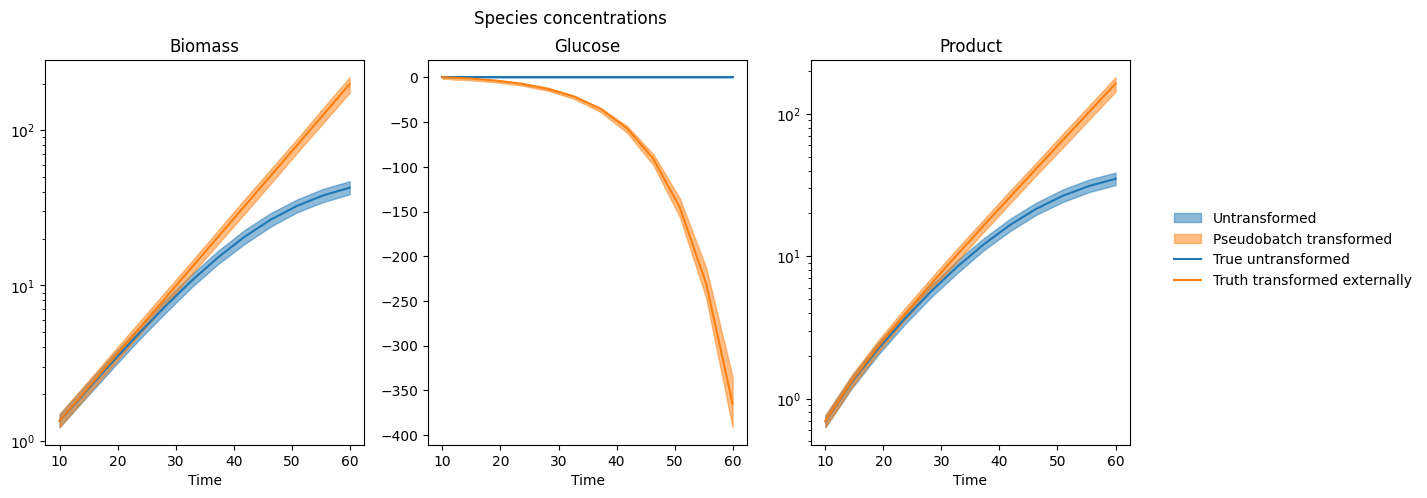

In [10]:
def plot_timecourse_qs(
    ax: plt.Axes,
    varname: str, 
    idata_group: xr.Dataset, 
    timepoints: pd.Series,
    coords: dict,
    quantiles: list = [0.025, 0.975],
    **fill_between_kwargs
) -> PolyCollection:
    var_draws = idata_group[varname]
    for k, v in coords.items():
        if k in var_draws.coords:
            var_draws = var_draws.sel({k:v})
    qs = var_draws.quantile(quantiles, dim=["chain", "draw"]).to_dataframe()[varname].unstack("quantile")
    low = qs[0.025].values
    high = qs[0.975].values
    x = timepoints.values
    return ax.fill_between(x, low, high, **fill_between_kwargs)


f, axes = plt.subplots(1, 3, figsize=[14, 5])
for ax, species in zip(axes, SPECIES):
    pcs = []
    line_patches = []
    for var, color in zip(["c", "pseudobatch_c"], ["tab:blue", "tab:orange"]):
        true_value_colname = "c_" + species if var == "c" else f"c_{species}_pseudobatch"
        pc = plot_timecourse_qs(
            ax,
            var,
            idata.posterior,
            samples["timestamp"],
            {"species": [species]},
            color=color,
            alpha=0.5,
        )
        pcs += [pc]
        line = ax.plot(samples["timestamp"], samples[true_value_colname], color=color)
        line_patches += [line[-1]]
    txt = ax.set(xlabel="Time", title=species)
    if all(samples[true_value_colname] > 0):
        ax.semilogy()

f.suptitle("Species concentrations")
legend = f.legend(
    [*pcs, *line_patches],
    ["Untransformed", "Pseudobatch transformed", "True untransformed", "Truth transformed externally"],
    ncol=1, 
    loc="right", 
    frameon=False,
    bbox_to_anchor = [1.11, 0.5]
)

## Estimating the growth rate

One thing that you might want to do with pseudobatch transformation is to estimate the measured cells' growth rate.

This can be done for each sample from our posterior distribution, giving us an idea of the range of growth rate estimates that are consistent with our model. Even better, since we used a simulated dataset we know that the true growth rate is 0.1, so we can compare our estimated growth rates with the truth.

draw,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
slope,0.100143,0.099022,0.100609,0.098897,0.101221,0.097586,0.101213,0.099533,0.099142,0.099776,...,0.097747,0.099063,0.099770,0.099853,0.099753,0.102094,0.099706,0.098495,0.099759,0.100351
intercept,-0.702822,-0.677803,-0.726413,-0.700252,-0.741412,-0.658849,-0.739395,-0.714704,-0.693713,-0.704035,...,-0.629544,-0.665296,-0.734138,-0.712960,-0.722524,-0.765367,-0.725016,-0.686792,-0.697855,-0.722775


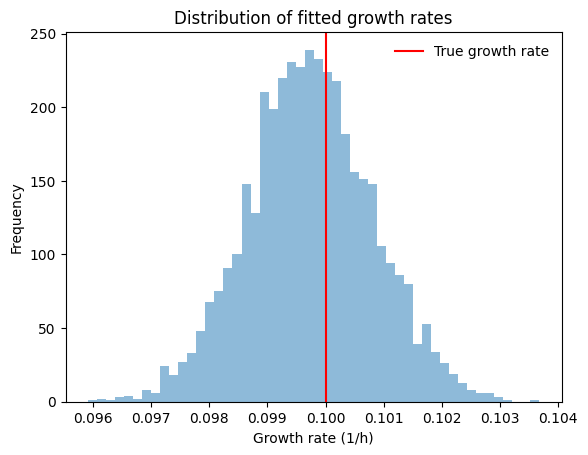

In [7]:
def fit_log_linear_model(y, x):
    logy = np.log(y.values)
    slope, intercept = np.polyfit(x, logy, deg=1)
    return xr.DataArray([slope, intercept])

growth_coeffs = pd.DataFrame(
    idata.posterior["pseudobatch_c"]
    .sel(species="Biomass")
    .stack(chaindraw=("chain", "draw"))
    .groupby("chaindraw")
    .map(fit_log_linear_model, x=samples["timestamp"], shortcut=True)
    .values, 
    columns=["slope", "intercept"]
)
growth_coeffs.index.name = "draw"

display(growth_coeffs.T)

f, ax = plt.subplots()
hist = ax.hist(growth_coeffs["slope"], bins=50, alpha=0.5)
vline = ax.axvline(samples["mu_true"].iloc[0], c="red", label="True growth rate")
txt = ax.set(
    xlabel="Growth rate (1/h)", 
    ylabel="Frequency", 
    title="Distribution of fitted growth rates"
)
leg = ax.legend(frameon=False)


# the 0.025, 0.5 and 0.975 quantiles of the fitted slopes
# print(fitted_growth_rates.slope.quantile([0.025, 0.5, 0.975]))

## Estimating yield coefficients

Glucose yield coefficients:


,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
slope,-1.826222,-1.847676,-1.861895,-1.889307,-1.862672,-1.931213,-1.940962,-1.896566,-1.914910,-1.824786,...,-1.807956,-1.782771,-1.858037,-1.790361,-1.901052,-1.777695,-1.832716,-1.863914,-1.833865,-1.748598
intercept,0.200233,1.756556,1.970141,-0.010857,1.726008,1.907585,1.810202,0.748339,2.875147,3.184774,...,2.008327,0.913351,0.672072,0.096839,1.049195,-0.653894,0.733378,2.019624,-0.171145,-1.535290


Product yield coefficients:


,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
slope,0.756576,0.865701,0.839009,0.780207,0.857693,0.794393,0.857131,0.784906,0.835964,0.857122,...,0.850460,0.804980,0.809967,0.829555,0.843611,0.781769,0.813733,0.815242,0.816113,0.755015
intercept,1.316265,-1.474687,-1.466398,1.202674,-2.171844,0.948141,-2.146443,1.511854,-0.869926,-1.363710,...,-1.494668,-0.817024,0.050081,0.308398,-0.989861,0.724107,0.059916,0.130305,-0.469104,1.026836


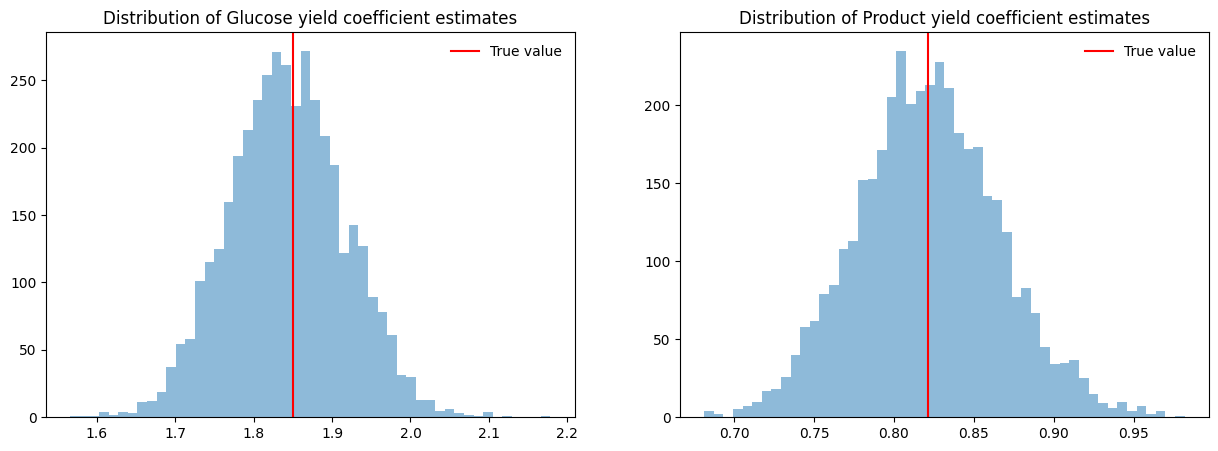

In [20]:
def fit_linear_model(y, x):
    slope, intercept = np.polyfit(x, y, deg=1)
    return xr.DataArray([slope, intercept])

yield_dfs = {}

for species in ["Glucose", "Product"]:
    yield_dfs[species] = pd.DataFrame(
        idata.posterior["pseudobatch_c"]
        .sel(species=["Biomass", species])
        .stack(chaindraw=["chain", "draw"])
        .groupby("chaindraw")
        .map(lambda arr: fit_linear_model(arr.sel(species=species), arr.sel(species="Biomass")))
        .values,
        columns=["slope", "intercept"]
    )
print("Glucose yield coefficients:")
display(yield_dfs["Glucose"].T)
print("Product yield coefficients:")
display(yield_dfs["Product"].T)

f, axes = plt.subplots(1, 2, figsize=[15, 5])
for ax, species, true_value_colname in zip(axes, ["Glucose", "Product"], ["Yxs", "Yxp"]):
    hist = ax.hist(np.abs(yield_dfs[species]["slope"]), bins=50, alpha=0.5)
    vline = ax.axvline(samples[true_value_colname].iloc[0], color="red", label="True value")
    title = ax.set(title=f"Distribution of {species} yield coefficient estimates")
    leg = ax.legend(frameon=False)
